# College Football Spread Betting Model

## Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from opponent_adjustments import get_opponent_adjustments
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import warnings
import math
from tqdm import tqdm
import optuna
import Model_Functions as MF

## Config Inputs

In [2]:
# Config - Major Inputs
DB_PATH = "cfb_data.db"
PRE_GAME_ELO_CSV_PATH = 'games_with_pregame_elo.csv'
#Define RP metrics to load and use
RP_METRICS_TO_USE =['usage','percentPPA']
# Define dfault value for missing RP data (e.g., average)
DEFAULT_RP_VALUE = 0.5
# Define how many weeks RP features should be active
RP_ACTIVE_WEEKS = 4
#Betting Parameters
BET_THRESHOLD = 1.5
WIN_PAYOUT = 0.909
LOSS_AMOUNT = 1
# EWMA Parameters
EWMA_SPAN = 5
min_periods_for_ewma = max(1, EWMA_SPAN // 2)
# Train / Test Split Years
TRAIN_END_SEASON = 2020
VALIDATION_END_SEASON = 2022
TEST_START_SEASON = VALIDATION_END_SEASON + 1
# XG Boost Params
# Define XGBoost parameters (use reasonable defaults or slightly tuned values)
# We are NOT tuning hyperparameters here, just evaluating feature sets
XGB_PARAMS = {
    'objective': 'reg:squarederror', # Regression task
    'eval_metric': 'rmse',           # Evaluation metric for XGBoost internal use
    'eta': 0.1,                      # Learning rate
    'max_depth': 5,                  # Max tree depth (control complexity)
    'subsample': 0.8,                # Fraction of samples used per tree
    'colsample_bytree': 0.8,         # Fraction of features used per tree
    'seed': 42,
    'nthread': -1, # Use all available CPU threads
    'device': 'cuda'
    # Enable internal NaN handling if using non-imputed data:
    # 'missing': np.nan # Tells XGBoost to handle NaNs
}
NUM_BOOST_ROUNDS = 100 # Number of boosting rounds (trees)

# Val Required Cols
VAL_REQUIRED_COLS = ['avg_opening_spread', 'homePoints', 'awayPoints', 'neutralSite', 'id', 'season', 'week', 'homeTeam', 'awayTeam', 'home_pregame_elo_calc', 'away_pregame_elo_calc']

In [ ]:
# RUN IF USING GOOGLE COLAB
MF.mount_with_colab()

## Phase 1: Data Foundation and Feature Engineering

In [3]:
# Load and Pre-Process Games Data
games_df = MF.preprocess_games_data(MF.load_games_data(DB_PATH))
# Add in Returning Production Data
rp_df = MF.preprocess_returning_prod_data(MF.load_returning_prod_data(DB_PATH, RP_METRICS_TO_USE), RP_METRICS_TO_USE, DEFAULT_RP_VALUE)
# Load Pre-Calculated ELO Ratings
pre_game_elo_df = MF.load_ELO_ratings(PRE_GAME_ELO_CSV_PATH)
# Merge Games and ELO Data
master_df = MF.merge_elo_to_games(games_df, pre_game_elo_df)
# Merge Returning Production to Games
master_df = MF.merge_returning_production_to_games(master_df, rp_df, RP_METRICS_TO_USE, DEFAULT_RP_VALUE)
# Add Opponent Adjustments to the Master DF
master_df = MF.add_opponent_adjustments(master_df)
# Drop Missing Targets and Sort Chronologically
master_df = MF.drop_missing_target_sort_chronologically(master_df)

Connecting to database: cfb_data.db
Loading ALL games data (including advanced stats)...
Loaded 10287 completed games with 142 columns.
Database connection closed.
Converting relevant columns to numeric...
Missing value check (post-numeric conversion):
  Column 'avg_closing_spread' missing: 0.93%
  Column 'homePoints' missing: 0.00%
  Column 'awayPoints' missing: 0.00%
Loading returning production data (['usage', 'percentPPA'])...
Loaded 1420 returning production records.
Database connection closed.
Preprocessing returning production data...
Filling NaNs in RP data with default: 0.5
Loading pre-game Elo ratings from: games_with_pregame_elo.csv
Loaded Elo ratings for 10287 games.
Loaded pre-game Elo ratings.
Merging games data with pre-game Elo ratings...
Merging returning production data...
Filling NaNs in merged RP column 'home_rp_usage' with 0.5


c:\Users\austi\Documents\Local Docs\github\BettingModels\Model_Functions.py:267: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df[col].fillna(DEFAULT_RP_VALUE, inplace=True)


Filling NaNs in merged RP column 'home_rp_percentPPA' with 0.5
Filling NaNs in merged RP column 'away_rp_usage' with 0.5
Filling NaNs in merged RP column 'away_rp_percentPPA' with 0.5

Creating hybrid league average columns...

Calculating lagged expanding team averages...


c:\Users\austi\Documents\Local Docs\github\BettingModels\opponent_adjustments.py:146: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[prev_season_col].fillna(0, inplace=True)
c:\Users\austi\Documents\Local Docs\github\BettingModels\opponent_adjustments.py:162: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

Filling initial team NaNs with 0.
DataFrame shape after revised merging: (10287, 298)

Applying Opponent Adjustments with Hybrid League Average...

Hybrid Opponent Adjustments Applied.
Dropping potentially duplicated columns: ['id_y', 'seasonType_y', 'completed_y', 'neutralSite_y', 'conferenceGame_y', 'attendance_y', 'homeConference_y', 'homeClassification_y', 'homePoints_y', 'homePostgameWinProbability_y', 'homePregameElo_y', 'homePostgameElo_y', 'awayConference_y', 'awayClassification_y', 'awayPoints_y', 'awayPostgameWinProbability_y', 'awayPregameElo_y', 'awayPostgameElo_y', 'avg_closing_spread_y', 'avg_closing_total_y', 'avg_opening_spread_y', 'avg_opening_total_y', 'home_offense_plays_y', 'home_offense_drives_y', 'home_offense_ppa_y', 'home_offense_totalPPA_y', 'home_offense_successRate_y', 'home_offense_explosiveness_y', 'home_offense_powerSuccess_y', 'home_offense_stuffRate_y', 'home_offense_lineYards_y', 'home_offense_lineYardsTotal_y', 'home_offense_secondLevelYards_y', 'home_

c:\Users\austi\Documents\Local Docs\github\BettingModels\opponent_adjustments.py:254: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  team_centric_df[col].fillna(0, inplace=True)


In [4]:
# Inspect Consolidated Data
print("\n--- Master DataFrame Info (Now includes all stats) ---")
master_df.info() # Will show many more columns now

# Displaying head/tail might be too wide, focus on key columns
print("\n--- Master DataFrame Head (Key Columns) ---")
print(master_df[['id', 'season', 'week', 'homeTeam', 'awayTeam',
                 'avg_closing_spread', 'avg_opening_spread',
                 'home_pregame_elo_calc', 'away_pregame_elo_calc']].head())

print("\n--- Master DataFrame Tail (Check Sorting - Key Columns) ---")
print(master_df[['id', 'season', 'week', 'homeTeam', 'awayTeam',
                 'avg_closing_spread', 'avg_opening_spread',
                 'home_pregame_elo_calc', 'away_pregame_elo_calc']].tail())


--- Master DataFrame Info (Now includes all stats) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10287 entries, 0 to 10286
Columns: 358 entries, id to adj_hybrid_away_defense_passingPlays_explosiveness
dtypes: float64(345), int64(6), object(7)
memory usage: 28.1+ MB

--- Master DataFrame Head (Key Columns) ---
          id  season  week        homeTeam          awayTeam  \
0  332410006    2013     1   South Alabama     Southern Utah   
1  332410023    2013     1  San José State  Sacramento State   
2  332410041    2013     1           UConn            Towson   
3  332410062    2013     1         Hawai'i               USC   
4  332410084    2013     1         Indiana     Indiana State   

   avg_closing_spread  avg_opening_spread  home_pregame_elo_calc  \
0          -41.000000                 NaN                 1790.0   
1          -33.000000                 NaN                 1790.0   
2          -20.000000                 NaN                 1790.0   
3           22.833333 

In [5]:
# Define Target Variable and Basic Features
target_variable, basic_features, master_df = MF.define_target_variable_basic_features(master_df)
# Identify Stats to Roll
stats_to_roll = MF.identify_stats_to_roll(EWMA_SPAN)
# Reshape data to team-centric format
team_game_df = MF.reshape_to_team_centric(master_df, stats_to_roll)
# Calculate Lagged EWMAs
team_game_df, ewma_cols_generated = MF.calculate_lagged_ewma(team_game_df, stats_to_roll, EWMA_SPAN, min_periods_for_ewma)
# Merge Back to Master DF
master_df = MF.merge_ewma_to_master_df(master_df, team_game_df, ewma_cols_generated)
# Create Matchup Features
master_df = MF.create_matchup_features(master_df, stats_to_roll)
# Create Returning Production Features
master_df, potential_features, basic_features = MF.create_returning_prod_features(master_df, RP_METRICS_TO_USE, RP_ACTIVE_WEEKS)


Target Variable: 'avg_closing_spread'
Missing values in target ('avg_closing_spread'): 0.93%
Missing values in target after dropping: 0

Basic Features Selected (7):
['home_pregame_elo_calc', 'away_pregame_elo_calc', 'neutralSite', 'conferenceGame', 'season', 'week', 'elo_diff_calc']
Selected 33 stats for EWMA (span=5).
Reshaping data to team-centric format...
Sorting team-centric data...
Calculating SEASONAL lagged EWMAs (span=5)...
Skipping EWMA for 'offense_lineYards' as column not found in team_game_df.
Skipping EWMA for 'defense_lineYards' as column not found in team_game_df.
Generated 32 EWMA columns.
Merging EWMA features back to master DataFrame...
Creating matchup features (differences)...
Generated 15 SEASONAL matchup difference features.
Created 2 RP difference features.
Created 6 conditionally active RP features (Weeks 1-4).

Updating potential features list...
Total potential features (incl. Seasonal EWMA & Conditional RP): 92


In [6]:
# Identify and Quantify Missing Data in Features
# Use the 'potential_features' list created at the end of Step 3
# If you didn't create it, define it again:
# all_engineered_features = [col for col in master_df.columns if '_ewma_lag1' in col or 'matchup_' in col]
# potential_features = basic_features + all_engineered_features # basic_features defined in step 2

# Calculate missing percentage for features we might use
print(f"Checking missing values for {len(potential_features)} potential features...")
missing_summary = master_df[potential_features].isnull().mean().sort_values(ascending=False) * 100
missing_summary = missing_summary[missing_summary > 0] # Filter to only show columns with missing data

print("\nFeatures with Missing Values (%):")
if missing_summary.empty:
    print("No missing values found in the potential feature set.")
else:
    with pd.option_context('display.max_rows', None): # Ensure all rows are printed
        print(missing_summary)

Checking missing values for 92 potential features...

Features with Missing Values (%):
matchup_HO_v_AD_ppa                                              3.434403
matchup_HO_v_AD_successRate                                      3.434403
matchup_HO_v_AD_standardDowns_successRate                        3.434403
matchup_HO_v_AD_passingDowns_successRate                         3.434403
matchup_HO_v_AD_standardDowns_explosiveness                      3.434403
matchup_HO_v_AD_rushingPlays_successRate                         3.434403
matchup_HO_v_AD_rushingPlays_ppa                                 3.434403
matchup_HO_v_AD_rushingPlays_explosiveness                       3.434403
matchup_HO_v_AD_passingPlays_ppa                                 3.434403
matchup_HO_v_AD_passingPlays_successRate                         3.434403
matchup_HO_v_AD_passingPlays_explosiveness                       3.434403
matchup_HO_v_AD_standardDowns_ppa                                3.434403
matchup_HO_v_AD_passingD

In [7]:
# Drop FCS Games
master_df = MF.drop_fcs_games(master_df)


--- Filtering Out Games Against FCS Opponents ---
Dropped 1170 games where away_team division is 'fcs'.
Remaining rows in master_df: 9021


## Phase 2: Feature Selection and Training

Splitting data chronologically:
  Training:   Seasons <= 2020
  Validation: Seasons > 2020 and <= 2022

Data Shapes:
  Training Set:   (5884, 446)
  Validation Set: (1547, 446)

Feature matrix shapes:
  X_train: (5884, 92)
  X_val:   (1547, 92)

Temporarily imputing NaNs with training set median for selection analysis...
Temporarily imputed 79 columns.
NaN check after imputation (X_train): 0
NaN check after imputation (X_val):   0

--- Filtering: Low Variance Features ---
Initial feature count: 92
Variance Threshold:    0.005
No features dropped by variance threshold.
Features remaining:    92

--- Filtering: High Missing Values (Check on Original Data) ---
Missing Value Threshold: > 90.0%
No features dropped by high missing value threshold.

--- Analysis: Feature-Target Correlation ---
Top 20 Features correlated with 'avg_closing_spread' (Absolute Value):
elo_diff_calc                                          0.869547
away_pregame_elo_calc                                  0.522127
hom

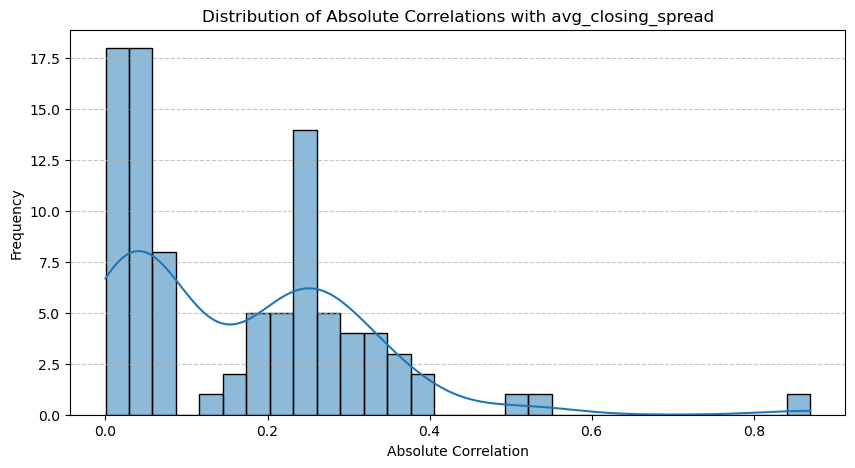


--- Analysis: Feature-Feature Correlation ---
Found 20 pairs with absolute correlation > 0.9

Highly Correlated Pairs (Feature1, Feature2, Correlation):
  - ('away_rp_percentPPA_Wk1_4' [0.049], 'away_rp_usage_Wk1_4' [0.051], 0.9798) -> Suggest dropping: 'away_rp_percentPPA_Wk1_4'
  - ('home_rp_percentPPA_Wk1_4' [0.073], 'home_rp_usage_Wk1_4' [0.077], 0.9788) -> Suggest dropping: 'home_rp_percentPPA_Wk1_4'
  - ('adj_hybrid_away_defense_standardDowns_successRate_ewma_lag1' [0.225], 'adj_hybrid_away_defense_successRate_ewma_lag1' [0.253], 0.9741) -> Suggest dropping: 'adj_hybrid_away_defense_standardDowns_successRate_ewma_lag1'
  - ('adj_hybrid_away_offense_standardDowns_successRate_ewma_lag1' [0.196], 'adj_hybrid_away_offense_successRate_ewma_lag1' [0.237], 0.9738) -> Suggest dropping: 'adj_hybrid_away_offense_standardDowns_successRate_ewma_lag1'
  - ('adj_hybrid_home_defense_standardDowns_successRate_ewma_lag1' [0.228], 'adj_hybrid_home_defense_successRate_ewma_lag1' [0.258], 0.9738) -

c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:03] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



Top 30 Features by XGBoost Importance (Gain):
                                              feature    importance
68                                      elo_diff_calc  17636.103516
69                              home_pregame_elo_calc   7142.695312
64                              away_pregame_elo_calc   5228.295410
87                                        neutralSite   1289.672607
22              adj_hybrid_away_offense_ppa_ewma_lag1    918.517700
67                                     conferenceGame    845.288757
61      adj_hybrid_home_offense_successRate_ewma_lag1    805.545166
54              adj_hybrid_home_offense_ppa_ewma_lag1    700.947937
46      adj_hybrid_home_defense_successRate_ewma_lag1    639.409363
14      adj_hybrid_away_defense_successRate_ewma_lag1    622.324036
39              adj_hybrid_home_defense_ppa_ewma_lag1    584.160645
29      adj_hybrid_away_offense_successRate_ewma_lag1    516.412964
90                                             season    491.080566
5

c:\Users\austi\Documents\Local Docs\github\BettingModels\Model_Functions.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30), palette='viridis')


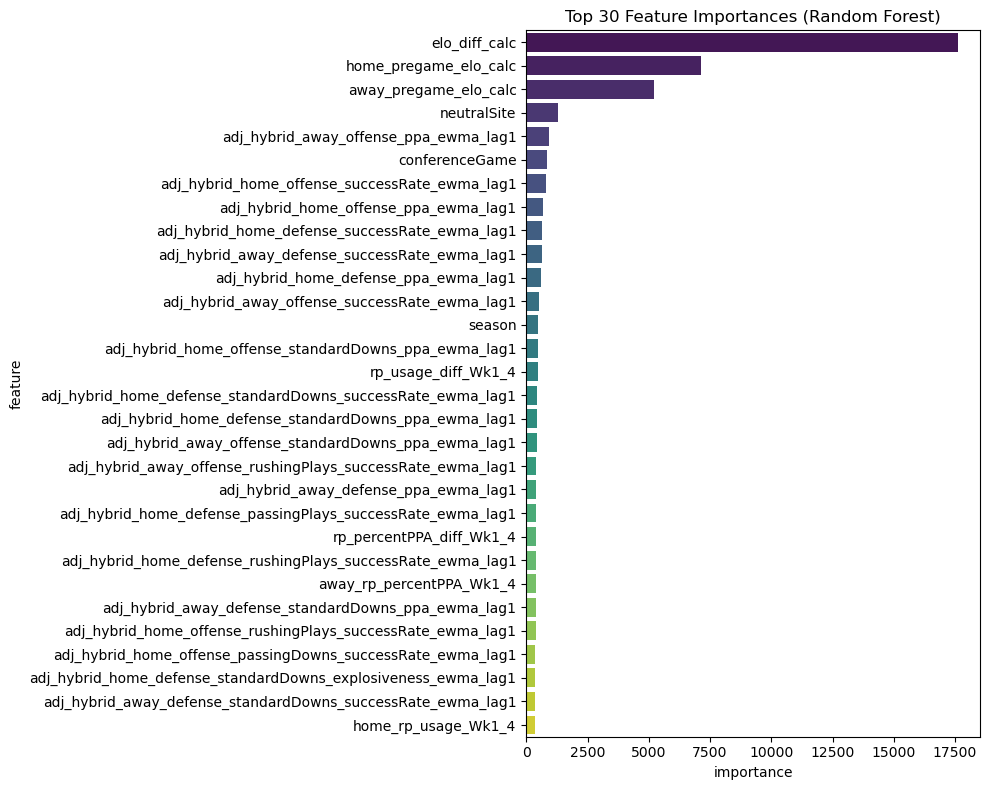


Features remaining after initial filtering & analysis: 92

--- Phase 2, Step 1 (Initial Analysis/Filtering) Complete ---

Defined 6 candidate feature sets:
  - A_Basic: 7 features
  - B_Top50_Corr: 50 features
  - C_Top50_RF_Importance: 50 features
  - D_Reduced_Correlation: 76 features
  - E_All_Initial_Filtered: 92 features
  - F_Top50_RF_plus_Basic: 50 features

--- Evaluating Feature Set: A_Basic (7 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


  RMSE: 6.1734, MAE: 4.8650, Correlation: 0.8942, Bias: 0.3769, Time: 0.4s

--- Evaluating Feature Set: B_Top50_Corr (50 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


  RMSE: 5.6777, MAE: 4.3732, Correlation: 0.9113, Bias: -0.2784, Time: 1.1s

--- Evaluating Feature Set: C_Top50_RF_Importance (50 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:06] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


  RMSE: 5.6834, MAE: 4.3580, Correlation: 0.9108, Bias: 0.2597, Time: 1.3s

--- Evaluating Feature Set: D_Reduced_Correlation (76 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:07] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


  RMSE: 5.7277, MAE: 4.4377, Correlation: 0.9092, Bias: 0.0546, Time: 1.7s

--- Evaluating Feature Set: E_All_Initial_Filtered (92 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:09] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


  RMSE: 5.7459, MAE: 4.4480, Correlation: 0.9086, Bias: 0.0234, Time: 1.7s

--- Evaluating Feature Set: F_Top50_RF_plus_Basic (50 features) ---


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:11] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


  RMSE: 5.6662, MAE: 4.3560, Correlation: 0.9115, Bias: 0.2916, Time: 1.0s

--- Feature Set Evaluation Summary ---
              Set Name  Num Features   RMSE    MAE Correlation    Bias Betting Units Betting Win Rate Betting ROI Eval Time (s)
E_All_Initial_Filtered            92 5.7459 4.4480      0.9086  0.0234          8.31           52.76%       0.72%           1.7
 F_Top50_RF_plus_Basic            50 5.6662 4.3560      0.9115  0.2916        -11.87           51.83%      -1.06%           1.0
 D_Reduced_Correlation            76 5.7277 4.4377      0.9092  0.0546        -30.33           51.00%      -2.64%           1.7
 C_Top50_RF_Importance            50 5.6834 4.3580      0.9108  0.2597        -30.69           50.99%      -2.65%           1.3
          B_Top50_Corr            50 5.6777 4.3732      0.9113 -0.2784        -31.96           50.92%      -2.80%           1.1
               A_Basic             7 6.1734 4.8650      0.8942  0.3769        -59.42           49.79%      -4.95%    

In [8]:
# Pepare Data and do Temporal Split
y_train, X_train, y_val, X_val, X_train_analysis, X_val_analysis, val_df, train_df = MF.temporal_split(TRAIN_END_SEASON, VALIDATION_END_SEASON, master_df, target_variable, potential_features)
# Do Initial Filtering
current_features = MF.perform_initial_filtering(X_train_analysis, X_train, train_df)
# Perform the Correlation Analysis
features_to_consider_dropping_corr, correlations_abs = MF.perform_target_correlation_analysis(X_train_analysis, y_train, current_features, target_variable)
# Perform Model Based Importance Analysis
features_after_initial_analysis, feature_importance_df = MF.perform_model_based_importance(X_train, X_train_analysis, y_train, current_features)
# Define Candidate Feature Sets
candidate_feature_sets = MF.define_candidate_feature_sets(basic_features, features_after_initial_analysis, features_to_consider_dropping_corr, feature_importance_df, correlations_abs)
# Run Feature Set Evaluation
all_results = MF.run_feature_set_evaluation(candidate_feature_sets, XGB_PARAMS, NUM_BOOST_ROUNDS, X_train, y_train, X_val, y_val, val_df, VAL_REQUIRED_COLS, WIN_PAYOUT, LOSS_AMOUNT, BET_THRESHOLD)
# Present Feature Set Evaluation Results
results_df = MF.present_feature_set_evaluation_results(all_results)

## Phase 3: Model Selection and Training

In [9]:
# Select Best Feature SEt
best_features = MF.select_best_feature_set(results_df, candidate_feature_sets, X_train, X_val)

Selected best feature set for tuning: 'E_All_Initial_Filtered' (92 features)
Using feature shapes: X_train_best=(5884, 92), X_val_best=(1547, 92)


In [10]:
# Run Optuna Study - LONG RUNNING CELL
study_hp = MF.run_optuna_study(X_train, X_val, y_train, y_val, val_df, best_features, VAL_REQUIRED_COLS, WIN_PAYOUT, LOSS_AMOUNT, BET_THRESHOLD)

[I 2025-06-09 17:52:24,758] A new study created in memory with name: XGBoost Spread Prediction NaN



Starting Optuna hyperparameter search (100 trials)...


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:24] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:27,015] Trial 0 finished with value: 6.149628275026659 and parameters: {'eta': 0.23322342087598993, 'max_depth': 8, 'subsample': 0.5882968537792322, 'colsample_bytree': 0.9424729748746548, 'min_child_weight': 1, 'gamma': 0.07708776602015893, 'lambda': 0.012176981133039057, 'alpha': 0.0008966175116846557}. Best is trial 0 with value: 6.149628275026659.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:27] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:29,372] Trial 1 finished with value: 5.7389926772286985 and parameters: {'eta': 0.103961258116334, 'max_depth': 8, 'subsample': 0.6902751057687206, 'colsample_bytree': 0.8018601066837168, 'min_child_weight': 7, 'gamma': 0.3217960120467121, 'lambda': 0.0008499974789730581, 'alpha': 8.347275543477229e-08}. Best is trial 1 with value: 5.7389926772286985.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:29] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:33,109] Trial 2 finished with value: 5.789783774337314 and parameters: {'eta': 0.07716654376090822, 'max_depth': 8, 'subsample': 0.7366081038764116, 'colsample_bytree': 0.7846126297171134, 'min_child_weight': 4, 'gamma': 0.0971478118983286, 'lambda': 0.0018322520639249382, 'alpha': 2.426640929204192e-05}. Best is trial 1 with value: 5.7389926772286985.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:33] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:35,623] Trial 3 finished with value: 5.635845947438026 and parameters: {'eta': 0.07312565969979931, 'max_depth': 6, 'subsample': 0.6850595390234935, 'colsample_bytree': 0.9281091010902085, 'min_child_weight': 8, 'gamma': 0.46370852224622905, 'lambda': 0.05431874652526943, 'alpha': 0.024000817250895735}. Best is trial 3 with value: 5.635845947438026.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:35] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:38,097] Trial 4 finished with value: 6.272309438886687 and parameters: {'eta': 0.2806907123053231, 'max_depth': 9, 'subsample': 0.8969016752702115, 'colsample_bytree': 0.5724998881283511, 'min_child_weight': 7, 'gamma': 0.20229194675161993, 'lambda': 5.804702876962251e-07, 'alpha': 4.276964849568664e-08}. Best is trial 3 with value: 5.635845947438026.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:38] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:40,520] Trial 5 finished with value: 5.771030708633793 and parameters: {'eta': 0.08343495496064879, 'max_depth': 7, 'subsample': 0.5260155583941442, 'colsample_bytree': 0.8368703991732671, 'min_child_weight': 3, 'gamma': 0.1371341704793309, 'lambda': 0.00018418814290216136, 'alpha': 4.134260150867132e-05}. Best is trial 3 with value: 5.635845947438026.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:40] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:45,249] Trial 6 finished with value: 5.712995680559677 and parameters: {'eta': 0.05243850923879404, 'max_depth': 7, 'subsample': 0.8715551083708807, 'colsample_bytree': 0.7443432710539376, 'min_child_weight': 3, 'gamma': 0.1355297314074242, 'lambda': 0.06664179652091604, 'alpha': 0.012694191811267144}. Best is trial 3 with value: 5.635845947438026.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:45] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:47,680] Trial 7 finished with value: 5.648825516879975 and parameters: {'eta': 0.056482095358934864, 'max_depth': 5, 'subsample': 0.8442014442092806, 'colsample_bytree': 0.9819682811088842, 'min_child_weight': 2, 'gamma': 0.09977379185973251, 'lambda': 0.13704260378257913, 'alpha': 0.00010328468813921759}. Best is trial 3 with value: 5.635845947438026.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:47] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:48,348] Trial 8 finished with value: 6.095363625703938 and parameters: {'eta': 0.2434361776578402, 'max_depth': 6, 'subsample': 0.7170133188953325, 'colsample_bytree': 0.54922651698073, 'min_child_weight': 3, 'gamma': 0.024650858020556166, 'lambda': 0.03715570005289542, 'alpha': 0.015417937091009307}. Best is trial 3 with value: 5.635845947438026.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:48] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:53,190] Trial 9 finished with value: 5.745000483556019 and parameters: {'eta': 0.01698422467494056, 'max_depth': 6, 'subsample': 0.8948488928855379, 'colsample_bytree': 0.9708158702040031, 'min_child_weight': 1, 'gamma': 0.19107998243899826, 'lambda': 7.273886552976757e-07, 'alpha': 8.329115918684509e-07}. Best is trial 3 with value: 5.635845947438026.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:54,487] Trial 10 finished with value: 5.852869412021534 and parameters: {'eta': 0.02475376181370302, 'max_depth': 3, 'subsample': 0.6145175939176843, 'colsample_bytree': 0.6519426419463846, 'min_child_weight': 10, 'gamma': 0.4863985214959968, 'lambda': 1.3534818744582727e-08, 'alpha': 0.28724138018837575}. Best is trial 3 with value: 5.635845947438026.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:54] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:56,405] Trial 11 finished with value: 5.647868528633543 and parameters: {'eta': 0.0426046797367851, 'max_depth': 4, 'subsample': 0.8081053345676595, 'colsample_bytree': 0.8999787720435259, 'min_child_weight': 10, 'gamma': 0.31496030570177425, 'lambda': 0.9710227673450433, 'alpha': 0.3622650659844606}. Best is trial 3 with value: 5.635845947438026.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:56] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:58,424] Trial 12 finished with value: 5.694008559966663 and parameters: {'eta': 0.031190986066581237, 'max_depth': 4, 'subsample': 0.8166300825549074, 'colsample_bytree': 0.8879171734559208, 'min_child_weight': 10, 'gamma': 0.3823446701799405, 'lambda': 0.9379941611749937, 'alpha': 0.33374853572473906}. Best is trial 3 with value: 5.635845947438026.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:58] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:52:59,704] Trial 13 finished with value: 5.624236266483185 and parameters: {'eta': 0.14582898473954817, 'max_depth': 3, 'subsample': 0.9987174664621308, 'colsample_bytree': 0.8845727520472805, 'min_child_weight': 8, 'gamma': 0.49975970222557153, 'lambda': 0.9212616252824557, 'alpha': 0.021522571363125628}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:59] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:01,323] Trial 14 finished with value: 5.65782627451526 and parameters: {'eta': 0.14654272809429023, 'max_depth': 3, 'subsample': 0.9520297421602197, 'colsample_bytree': 0.8720096154256851, 'min_child_weight': 8, 'gamma': 0.48507493079526254, 'lambda': 1.2291611154839728e-05, 'alpha': 0.008327635635224206}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:01] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:02,779] Trial 15 finished with value: 5.726135032314334 and parameters: {'eta': 0.136489438370733, 'max_depth': 5, 'subsample': 0.9837174113300939, 'colsample_bytree': 0.7037441994392211, 'min_child_weight': 8, 'gamma': 0.44301090978207514, 'lambda': 0.005243223029756707, 'alpha': 0.001800265399781186}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:02] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:04,886] Trial 16 finished with value: 6.203852452262782 and parameters: {'eta': 0.010973528738848186, 'max_depth': 4, 'subsample': 0.6243947455226895, 'colsample_bytree': 0.9231906672100962, 'min_child_weight': 6, 'gamma': 0.4026355674030631, 'lambda': 0.17433794513928738, 'alpha': 0.05378733542497274}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:05,874] Trial 17 finished with value: 5.803199008027175 and parameters: {'eta': 0.1567315316275224, 'max_depth': 5, 'subsample': 0.6715213989287248, 'colsample_bytree': 0.8444289737609934, 'min_child_weight': 8, 'gamma': 0.31865674279817086, 'lambda': 3.5761719021830653e-05, 'alpha': 0.0005533791086305507}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:07,296] Trial 18 finished with value: 5.63492536574255 and parameters: {'eta': 0.09947180080930837, 'max_depth': 3, 'subsample': 0.7778025018670658, 'colsample_bytree': 0.9840536354261239, 'min_child_weight': 5, 'gamma': 0.40565326904264937, 'lambda': 0.00033727436090340637, 'alpha': 3.2087011752015354e-06}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:07] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:08,130] Trial 19 finished with value: 5.687993260677517 and parameters: {'eta': 0.17912565991756269, 'max_depth': 3, 'subsample': 0.7737766119619711, 'colsample_bytree': 0.966739733402039, 'min_child_weight': 5, 'gamma': 0.39513714409986006, 'lambda': 9.271054588171092e-06, 'alpha': 1.7823115403193935e-06}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:08] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:09,234] Trial 20 finished with value: 5.683703029142249 and parameters: {'eta': 0.1077101154880849, 'max_depth': 4, 'subsample': 0.9378016435724847, 'colsample_bytree': 0.648002917037911, 'min_child_weight': 5, 'gamma': 0.2707516068367368, 'lambda': 0.0002680638774895906, 'alpha': 4.508185793276301e-06}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:09] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:10,766] Trial 21 finished with value: 5.6809250073151105 and parameters: {'eta': 0.0725775696801961, 'max_depth': 3, 'subsample': 0.5130508072851597, 'colsample_bytree': 0.9929400755458108, 'min_child_weight': 9, 'gamma': 0.43136259323236636, 'lambda': 0.01378993029835628, 'alpha': 0.00019394812521269782}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:10] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:12,620] Trial 22 finished with value: 5.720032084187186 and parameters: {'eta': 0.10551661973504467, 'max_depth': 6, 'subsample': 0.6595953315076581, 'colsample_bytree': 0.9250127880414161, 'min_child_weight': 6, 'gamma': 0.49961289739743936, 'lambda': 0.2724204907710962, 'alpha': 2.948062857564825e-07}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:12] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:15,223] Trial 23 finished with value: 5.630434808829607 and parameters: {'eta': 0.058681832922705186, 'max_depth': 5, 'subsample': 0.7736624725364674, 'colsample_bytree': 0.9986131952343228, 'min_child_weight': 7, 'gamma': 0.44665673987508375, 'lambda': 0.0046406284696526075, 'alpha': 1.082267267630857e-08}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:15] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:17,403] Trial 24 finished with value: 5.6497035324167895 and parameters: {'eta': 0.034818700610281084, 'max_depth': 4, 'subsample': 0.7693405109765133, 'colsample_bytree': 0.9978929791396531, 'min_child_weight': 7, 'gamma': 0.3609205978884762, 'lambda': 0.0015679628961672578, 'alpha': 2.459027643030216e-08}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:17] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:18,162] Trial 25 finished with value: 5.674555335038364 and parameters: {'eta': 0.19409120491945533, 'max_depth': 3, 'subsample': 0.7990722694244828, 'colsample_bytree': 0.9492159579328407, 'min_child_weight': 6, 'gamma': 0.4292287687188372, 'lambda': 5.4144915721028196e-05, 'alpha': 1.2563655490063144e-08}. Best is trial 13 with value: 5.624236266483185.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:18] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:20,636] Trial 26 finished with value: 5.614383513884981 and parameters: {'eta': 0.05629101532613232, 'max_depth': 5, 'subsample': 0.9952171561008266, 'colsample_bytree': 0.8476627387874328, 'min_child_weight': 4, 'gamma': 0.36746863845854316, 'lambda': 0.0004087135766985263, 'alpha': 8.304445948356361e-06}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:20] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:23,504] Trial 27 finished with value: 5.652760462314658 and parameters: {'eta': 0.052930501711467834, 'max_depth': 5, 'subsample': 0.996599222133126, 'colsample_bytree': 0.8422723485680187, 'min_child_weight': 4, 'gamma': 0.3508556063813437, 'lambda': 0.004793777101767145, 'alpha': 1.4003411517578958e-05}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:23] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:26,152] Trial 28 finished with value: 5.718929338637121 and parameters: {'eta': 0.020379968343925012, 'max_depth': 5, 'subsample': 0.9518321310915244, 'colsample_bytree': 0.798864984288401, 'min_child_weight': 9, 'gamma': 0.2721305294458073, 'lambda': 7.982398866092185e-07, 'alpha': 3.0196932848353855e-07}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:26] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:31,583] Trial 29 finished with value: 5.694786693582796 and parameters: {'eta': 0.037665096757137986, 'max_depth': 7, 'subsample': 0.9180668815190656, 'colsample_bytree': 0.8583031829258524, 'min_child_weight': 4, 'gamma': 0.4578940185316685, 'lambda': 0.007543298788343856, 'alpha': 0.002264009067074801}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:31] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:33,301] Trial 30 finished with value: 5.673363682170051 and parameters: {'eta': 0.06376959255769854, 'max_depth': 4, 'subsample': 0.973350921823765, 'colsample_bytree': 0.756140009993462, 'min_child_weight': 9, 'gamma': 0.35033041263097364, 'lambda': 3.4907234383659885e-06, 'alpha': 1.8306013189588756e-07}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:33] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:34,446] Trial 31 finished with value: 5.668512917050265 and parameters: {'eta': 0.12280642943037785, 'max_depth': 3, 'subsample': 0.852384142783157, 'colsample_bytree': 0.900196039260297, 'min_child_weight': 5, 'gamma': 0.4079321171623938, 'lambda': 0.0005688767788268559, 'alpha': 4.590910362753418e-06}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:34] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:35,566] Trial 32 finished with value: 5.663632442878034 and parameters: {'eta': 0.09744980766129395, 'max_depth': 4, 'subsample': 0.5489698033847895, 'colsample_bytree': 0.9533380896958059, 'min_child_weight': 7, 'gamma': 0.46069624770708045, 'lambda': 0.00031530763370057955, 'alpha': 1.0924438008754286e-06}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:35] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:38,327] Trial 33 finished with value: 5.643035957241507 and parameters: {'eta': 0.04498809657055165, 'max_depth': 5, 'subsample': 0.7450713208843327, 'colsample_bytree': 0.8146984126199923, 'min_child_weight': 6, 'gamma': 0.41978371469828074, 'lambda': 0.001131699903992838, 'alpha': 6.262431028558478e-06}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:38] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:39,776] Trial 34 finished with value: 5.622924654508231 and parameters: {'eta': 0.08287884877489504, 'max_depth': 3, 'subsample': 0.7159766797386837, 'colsample_bytree': 0.9232893740717427, 'min_child_weight': 4, 'gamma': 0.38070464834765716, 'lambda': 9.53666793618554e-05, 'alpha': 0.00047322826417901896}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:39] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:41,516] Trial 35 finished with value: 5.629684644203369 and parameters: {'eta': 0.06930579658880208, 'max_depth': 4, 'subsample': 0.7110549465876959, 'colsample_bytree': 0.9140367155253969, 'min_child_weight': 4, 'gamma': 0.36408622762032633, 'lambda': 8.829273871844155e-05, 'alpha': 0.1011090185142735}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:41] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:43,135] Trial 36 finished with value: 5.657655901041513 and parameters: {'eta': 0.08349030407379994, 'max_depth': 4, 'subsample': 0.7200166338435502, 'colsample_bytree': 0.8887304681144533, 'min_child_weight': 4, 'gamma': 0.22956869633264723, 'lambda': 6.955622825053215e-05, 'alpha': 0.11840673462130165}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:43] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:50,376] Trial 37 finished with value: 5.827788621068201 and parameters: {'eta': 0.06950802578249637, 'max_depth': 9, 'subsample': 0.6960647428791792, 'colsample_bytree': 0.8181279484500443, 'min_child_weight': 2, 'gamma': 0.29248967652961233, 'lambda': 4.090416879505785e-08, 'alpha': 0.0042391990031603495}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:50] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:51,903] Trial 38 finished with value: 5.616077841182161 and parameters: {'eta': 0.08735899133039549, 'max_depth': 3, 'subsample': 0.6421072703564826, 'colsample_bytree': 0.9225360870163938, 'min_child_weight': 3, 'gamma': 0.3736036569918031, 'lambda': 3.2364196500909823e-06, 'alpha': 0.0003849084552699913}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:52] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:53,089] Trial 39 finished with value: 5.742107167395657 and parameters: {'eta': 0.08307583025438603, 'max_depth': 3, 'subsample': 0.5662149109589573, 'colsample_bytree': 0.7806402849922818, 'min_child_weight': 2, 'gamma': 0.3308615429692475, 'lambda': 1.6533139109730998e-07, 'alpha': 0.00039435617085876567}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:54,937] Trial 40 finished with value: 6.150230612982734 and parameters: {'eta': 0.2345880151600491, 'max_depth': 8, 'subsample': 0.6432828989020095, 'colsample_bytree': 0.8774564303348594, 'min_child_weight': 3, 'gamma': 0.21950994558517709, 'lambda': 2.678680487795597e-06, 'alpha': 7.803154804695549e-05}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:55] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:56,265] Trial 41 finished with value: 5.681919542093686 and parameters: {'eta': 0.04704303605457024, 'max_depth': 3, 'subsample': 0.7010232895124298, 'colsample_bytree': 0.9167316170494741, 'min_child_weight': 4, 'gamma': 0.3863254067870781, 'lambda': 1.8734414147326314e-05, 'alpha': 0.9169003818411523}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:56] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:57,650] Trial 42 finished with value: 5.670276669246495 and parameters: {'eta': 0.08776228279989227, 'max_depth': 4, 'subsample': 0.5901683589247455, 'colsample_bytree': 0.9455313409990489, 'min_child_weight': 3, 'gamma': 0.3586001533288965, 'lambda': 0.00013125272122390546, 'alpha': 0.0011191257273848918}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:57] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:53:59,233] Trial 43 finished with value: 5.686975934616831 and parameters: {'eta': 0.06413390132886494, 'max_depth': 3, 'subsample': 0.6432850794966475, 'colsample_bytree': 0.910577743729377, 'min_child_weight': 3, 'gamma': 0.2891400727791719, 'lambda': 5.135154931818709e-06, 'alpha': 0.05112308933954237}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:53:59] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:00,421] Trial 44 finished with value: 5.643295010646137 and parameters: {'eta': 0.1179425288565162, 'max_depth': 4, 'subsample': 0.7236206679769093, 'colsample_bytree': 0.8614111281632417, 'min_child_weight': 4, 'gamma': 0.1732726583665697, 'lambda': 2.1135424622392197e-07, 'alpha': 0.0001873321849310833}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:00] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:01,066] Trial 45 finished with value: 5.77192680408572 and parameters: {'eta': 0.29453938665929463, 'max_depth': 3, 'subsample': 0.6031655460817583, 'colsample_bytree': 0.9303189914535821, 'min_child_weight': 1, 'gamma': 0.3728050775764163, 'lambda': 1.3915928279930947e-06, 'alpha': 2.357060565946523e-05}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:01] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:01,838] Trial 46 finished with value: 5.830355938270855 and parameters: {'eta': 0.18740302722052346, 'max_depth': 3, 'subsample': 0.8849556737314056, 'colsample_bytree': 0.5011141559167746, 'min_child_weight': 2, 'gamma': 0.3390411534820682, 'lambda': 0.022644747539739968, 'alpha': 0.03238869393618362}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:01] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:03,216] Trial 47 finished with value: 5.712905371733706 and parameters: {'eta': 0.12264789673450127, 'max_depth': 4, 'subsample': 0.6927690121362726, 'colsample_bytree': 0.8272341301938463, 'min_child_weight': 4, 'gamma': 0.30024350298098557, 'lambda': 2.5114997299231517e-05, 'alpha': 0.005497150253751111}. Best is trial 26 with value: 5.614383513884981.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:03] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:05,331] Trial 48 finished with value: 5.609299801844325 and parameters: {'eta': 0.0719735578917173, 'max_depth': 4, 'subsample': 0.91423327835751, 'colsample_bytree': 0.8627797349986317, 'min_child_weight': 5, 'gamma': 0.46983071887243266, 'lambda': 0.00013038992049843275, 'alpha': 4.8857153056677294e-05}. Best is trial 48 with value: 5.609299801844325.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:06,823] Trial 49 finished with value: 5.7712899402752225 and parameters: {'eta': 0.1562529598119478, 'max_depth': 6, 'subsample': 0.9220082063889449, 'colsample_bytree': 0.8653795488872776, 'min_child_weight': 5, 'gamma': 0.4752485286238422, 'lambda': 0.0024449214857951446, 'alpha': 4.227212737869174e-05}. Best is trial 48 with value: 5.609299801844325.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:06] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:08,247] Trial 50 finished with value: 5.703614029894708 and parameters: {'eta': 0.050181944727293815, 'max_depth': 3, 'subsample': 0.967563829973243, 'colsample_bytree': 0.7161436671149539, 'min_child_weight': 3, 'gamma': 0.006597236261549622, 'lambda': 1.265243236917891e-07, 'alpha': 1.3548244610494137e-05}. Best is trial 48 with value: 5.609299801844325.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:08] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:10,270] Trial 51 finished with value: 5.605582211275936 and parameters: {'eta': 0.07436443757734908, 'max_depth': 4, 'subsample': 0.9201431625782656, 'colsample_bytree': 0.8887798535900433, 'min_child_weight': 5, 'gamma': 0.4716887456570429, 'lambda': 0.0006794250778558566, 'alpha': 0.14897607293771434}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:10] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:11,784] Trial 52 finished with value: 5.65414685462051 and parameters: {'eta': 0.09171232528352098, 'max_depth': 4, 'subsample': 0.9916000271421178, 'colsample_bytree': 0.8824969956587713, 'min_child_weight': 5, 'gamma': 0.49538577029777375, 'lambda': 0.000577466473226037, 'alpha': 0.0004608865237639177}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:11] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:13,630] Trial 53 finished with value: 5.635648860035981 and parameters: {'eta': 0.0775490976554092, 'max_depth': 5, 'subsample': 0.9193916123467658, 'colsample_bytree': 0.8441646293447774, 'min_child_weight': 5, 'gamma': 0.47542618561664995, 'lambda': 0.00015771545153463567, 'alpha': 0.016110667807726287}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:13] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:15,184] Trial 54 finished with value: 5.656242399310786 and parameters: {'eta': 0.059464204247223304, 'max_depth': 3, 'subsample': 0.850309505965944, 'colsample_bytree': 0.9664838448951554, 'min_child_weight': 6, 'gamma': 0.4466862826392079, 'lambda': 9.16951863754873e-06, 'alpha': 0.00016454947175995234}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:15] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:16,501] Trial 55 finished with value: 5.77801165404514 and parameters: {'eta': 0.039763362250773704, 'max_depth': 3, 'subsample': 0.9554802599906285, 'colsample_bytree': 0.780288696312667, 'min_child_weight': 5, 'gamma': 0.42163533061970637, 'lambda': 0.05083924896611497, 'alpha': 4.35732226210037e-05}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:16] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:18,450] Trial 56 finished with value: 5.638941879692395 and parameters: {'eta': 0.07518969763853657, 'max_depth': 5, 'subsample': 0.8732802063689213, 'colsample_bytree': 0.8965601036374299, 'min_child_weight': 4, 'gamma': 0.47461448025164965, 'lambda': 0.3961833105083724, 'alpha': 0.8305910560695977}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:18] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:19,907] Trial 57 finished with value: 5.69964645166733 and parameters: {'eta': 0.13956529879949342, 'max_depth': 6, 'subsample': 0.9015916846497432, 'colsample_bytree': 0.9368747889141744, 'min_child_weight': 3, 'gamma': 0.38698097650526225, 'lambda': 0.0024169028031449124, 'alpha': 0.20663515876009628}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:20] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:21,970] Trial 58 finished with value: 5.712681556718057 and parameters: {'eta': 0.030590499413757806, 'max_depth': 4, 'subsample': 0.9684308258145232, 'colsample_bytree': 0.8495583929032506, 'min_child_weight': 6, 'gamma': 0.4388140245701102, 'lambda': 3.802411720136118e-05, 'alpha': 7.351999517150583e-05}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:22] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:23,408] Trial 59 finished with value: 5.678536003967779 and parameters: {'eta': 0.05503859381188374, 'max_depth': 3, 'subsample': 0.9991302762865313, 'colsample_bytree': 0.8740117585707917, 'min_child_weight': 5, 'gamma': 0.46079626773908955, 'lambda': 0.09255979636929156, 'alpha': 0.001164798875483624}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:23] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:24,575] Trial 60 finished with value: 5.6845302687447505 and parameters: {'eta': 0.1111648421770033, 'max_depth': 4, 'subsample': 0.8253102640548543, 'colsample_bytree': 0.9694589023712703, 'min_child_weight': 3, 'gamma': 0.49829379886947345, 'lambda': 0.0010050186072286978, 'alpha': 1.3370539817284249e-05}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:24] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:26,348] Trial 61 finished with value: 5.663926233821794 and parameters: {'eta': 0.07248937996949237, 'max_depth': 4, 'subsample': 0.6723077128872531, 'colsample_bytree': 0.9082352565574915, 'min_child_weight': 4, 'gamma': 0.37178391952526824, 'lambda': 9.175386479521477e-05, 'alpha': 0.1261617912183356}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:26] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:28,104] Trial 62 finished with value: 5.640767854956394 and parameters: {'eta': 0.06535744241242283, 'max_depth': 4, 'subsample': 0.749465002385892, 'colsample_bytree': 0.919750058406427, 'min_child_weight': 4, 'gamma': 0.408915011757441, 'lambda': 0.00023198273477286033, 'alpha': 0.09304777718602168}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:28] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:29,416] Trial 63 finished with value: 5.671523243379908 and parameters: {'eta': 0.09175222663868028, 'max_depth': 3, 'subsample': 0.932279031620847, 'colsample_bytree': 0.8981483940008762, 'min_child_weight': 4, 'gamma': 0.31156213059220994, 'lambda': 0.000588825345975867, 'alpha': 0.02612153763093395}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:29] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:31,997] Trial 64 finished with value: 5.629948812888813 and parameters: {'eta': 0.06073689831317247, 'max_depth': 5, 'subsample': 0.9379627086992304, 'colsample_bytree': 0.9585358513285083, 'min_child_weight': 5, 'gamma': 0.44967908271789836, 'lambda': 4.730761896989746e-05, 'alpha': 0.3873572663482927}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:32] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:33,819] Trial 65 finished with value: 5.637196488757164 and parameters: {'eta': 0.050022485041056004, 'max_depth': 4, 'subsample': 0.9803094637948, 'colsample_bytree': 0.9377210790517532, 'min_child_weight': 4, 'gamma': 0.42255041682866795, 'lambda': 1.2648214951390735e-05, 'alpha': 0.054463637407200866}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:33] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:35,255] Trial 66 finished with value: 5.628460866552996 and parameters: {'eta': 0.10053550215942933, 'max_depth': 3, 'subsample': 0.9012331792549049, 'colsample_bytree': 0.8257078266681118, 'min_child_weight': 6, 'gamma': 0.25388038518773043, 'lambda': 7.161833585587584e-05, 'alpha': 0.00858544536333725}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:35] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:36,399] Trial 67 finished with value: 5.6622191508561945 and parameters: {'eta': 0.12863324122076764, 'max_depth': 3, 'subsample': 0.9533266653355952, 'colsample_bytree': 0.7972686915270821, 'min_child_weight': 7, 'gamma': 0.06535952612693896, 'lambda': 0.000449548087811544, 'alpha': 0.002608269723975215}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:36] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:37,787] Trial 68 finished with value: 5.611875631023548 and parameters: {'eta': 0.09847407857004059, 'max_depth': 3, 'subsample': 0.8940518902887289, 'colsample_bytree': 0.827070410766013, 'min_child_weight': 8, 'gamma': 0.2529008211140752, 'lambda': 3.9295854440411694e-07, 'alpha': 0.00844463951660941}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:37] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:39,113] Trial 69 finished with value: 5.670612191648811 and parameters: {'eta': 0.08090314445769563, 'max_depth': 3, 'subsample': 0.8665306205729987, 'colsample_bytree': 0.7599922352465076, 'min_child_weight': 9, 'gamma': 0.15591230842384243, 'lambda': 4.875699728602804e-07, 'alpha': 0.00024114436792619054}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:39] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:40,509] Trial 70 finished with value: 5.649465852125267 and parameters: {'eta': 0.10641359878783789, 'max_depth': 3, 'subsample': 0.8293792668511115, 'colsample_bytree': 0.8318217884507908, 'min_child_weight': 8, 'gamma': 0.10498394188095006, 'lambda': 3.1631180908943096e-07, 'alpha': 0.0006692605412913828}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:40] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:41,556] Trial 71 finished with value: 5.757921876124335 and parameters: {'eta': 0.21039029872265655, 'max_depth': 3, 'subsample': 0.9073969006190006, 'colsample_bytree': 0.8127414635586208, 'min_child_weight': 8, 'gamma': 0.2361947608591278, 'lambda': 3.950084367362959e-08, 'alpha': 0.010920508039754914}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:41] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:47,096] Trial 72 finished with value: 6.074279757905084 and parameters: {'eta': 0.010125575047078048, 'max_depth': 7, 'subsample': 0.7941596072500229, 'colsample_bytree': 0.8623811870328402, 'min_child_weight': 7, 'gamma': 0.20124397787744935, 'lambda': 6.418154316160145e-06, 'alpha': 0.002848051819134404}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:47] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:48,321] Trial 73 finished with value: 5.638440251573096 and parameters: {'eta': 0.10024572087889512, 'max_depth': 3, 'subsample': 0.8919903073918829, 'colsample_bytree': 0.8519423548099496, 'min_child_weight': 8, 'gamma': 0.2718386146195897, 'lambda': 1.0131823758706864e-06, 'alpha': 0.008585181870483356}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:48] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:49,377] Trial 74 finished with value: 5.678769514293263 and parameters: {'eta': 0.17101632158048646, 'max_depth': 3, 'subsample': 0.9407557059391912, 'colsample_bytree': 0.8926827385539416, 'min_child_weight': 9, 'gamma': 0.2546080540874218, 'lambda': 1.943737707768551e-06, 'alpha': 0.004145415622023645}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:49] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:50,667] Trial 75 finished with value: 5.650589823897487 and parameters: {'eta': 0.09393471655229985, 'max_depth': 3, 'subsample': 0.879370584547891, 'colsample_bytree': 0.8262063591809359, 'min_child_weight': 7, 'gamma': 0.25482995022066696, 'lambda': 2.5195054033206723e-05, 'alpha': 0.014562931163638075}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:50] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:52,115] Trial 76 finished with value: 5.620126515111111 and parameters: {'eta': 0.08527337568932447, 'max_depth': 3, 'subsample': 0.8638726346556929, 'colsample_bytree': 0.8799635520880524, 'min_child_weight': 10, 'gamma': 0.3326742185940082, 'lambda': 8.097674350807011e-08, 'alpha': 1.927733210785105e-06}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:52] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:53,601] Trial 77 finished with value: 5.692742375104521 and parameters: {'eta': 0.08413792348611228, 'max_depth': 4, 'subsample': 0.8637652499521802, 'colsample_bytree': 0.8790839008969575, 'min_child_weight': 10, 'gamma': 0.33550037337735905, 'lambda': 3.786349491275809e-08, 'alpha': 7.379005610638217e-07}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:53] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:54,961] Trial 78 finished with value: 5.666683597403596 and parameters: {'eta': 0.06794025392877184, 'max_depth': 3, 'subsample': 0.9156522679880641, 'colsample_bytree': 0.6471108897394885, 'min_child_weight': 10, 'gamma': 0.39727825722366067, 'lambda': 3.7034816060240176e-07, 'alpha': 2.0585514206400474e-06}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:55] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:55,877] Trial 79 finished with value: 5.8950944571739035 and parameters: {'eta': 0.26345330879594137, 'max_depth': 5, 'subsample': 0.9835567152783043, 'colsample_bytree': 0.869121932827432, 'min_child_weight': 9, 'gamma': 0.4846921394909858, 'lambda': 8.585661465575639e-08, 'alpha': 6.4410111181564255e-06}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:56] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:57,781] Trial 80 finished with value: 5.651400195839078 and parameters: {'eta': 0.07731163485723992, 'max_depth': 4, 'subsample': 0.8390843603333461, 'colsample_bytree': 0.9284366949765616, 'min_child_weight': 10, 'gamma': 0.3418708072859489, 'lambda': 1.3325090201260803e-08, 'alpha': 2.085294368577076e-05}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:57] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:54:59,319] Trial 81 finished with value: 5.641727119063064 and parameters: {'eta': 0.10777003765026533, 'max_depth': 3, 'subsample': 0.9031299038578048, 'colsample_bytree': 0.8378769580496108, 'min_child_weight': 6, 'gamma': 0.27976483201520264, 'lambda': 0.0001883156270062545, 'alpha': 0.001241200576904779}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:54:59] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:00,368] Trial 82 finished with value: 5.657537988024926 and parameters: {'eta': 0.13250878565519195, 'max_depth': 3, 'subsample': 0.9624540969186769, 'colsample_bytree': 0.7916137003716801, 'min_child_weight': 6, 'gamma': 0.32578510694161117, 'lambda': 0.00950126847205971, 'alpha': 8.653098068576851e-06}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:00] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:02,129] Trial 83 finished with value: 5.633440224741054 and parameters: {'eta': 0.08782478750960551, 'max_depth': 3, 'subsample': 0.8597405757667876, 'colsample_bytree': 0.8828371557951804, 'min_child_weight': 5, 'gamma': 0.310936621083317, 'lambda': 0.0001182770074114511, 'alpha': 0.0002700657244561474}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:02] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:03,446] Trial 84 finished with value: 5.6472926572554725 and parameters: {'eta': 0.11672457311291069, 'max_depth': 3, 'subsample': 0.8894560673328618, 'colsample_bytree': 0.8121821273583066, 'min_child_weight': 9, 'gamma': 0.2178159074299047, 'lambda': 6.332774599442696e-08, 'alpha': 2.7286095144742826e-06}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:03] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:05,009] Trial 85 finished with value: 5.6813811046054665 and parameters: {'eta': 0.059016578416975995, 'max_depth': 3, 'subsample': 0.930003692960858, 'colsample_bytree': 0.8536893894723618, 'min_child_weight': 8, 'gamma': 0.4353887790101899, 'lambda': 1.8127972494462504e-08, 'alpha': 0.05062708029249241}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:05] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:06,270] Trial 86 finished with value: 5.709023219271254 and parameters: {'eta': 0.14543209698502385, 'max_depth': 4, 'subsample': 0.9465146257729835, 'colsample_bytree': 0.7701513746330497, 'min_child_weight': 6, 'gamma': 0.37461989827007686, 'lambda': 6.628530509218687e-05, 'alpha': 0.006140277705848484}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:06] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:07,902] Trial 87 finished with value: 5.634602353758608 and parameters: {'eta': 0.09792156067169464, 'max_depth': 3, 'subsample': 0.6285922938217589, 'colsample_bytree': 0.9082231031057881, 'min_child_weight': 3, 'gamma': 0.2420320638100827, 'lambda': 0.0016222641289632797, 'alpha': 0.00013430817959427988}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:08] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:09,213] Trial 88 finished with value: 5.6454015084189955 and parameters: {'eta': 0.16172974249969366, 'max_depth': 3, 'subsample': 0.9085536085713635, 'colsample_bytree': 0.8908125592888138, 'min_child_weight': 5, 'gamma': 0.3535140692941485, 'lambda': 0.0003238577152117438, 'alpha': 5.223271740126748e-05}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:09] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:10,959] Trial 89 finished with value: 5.700293855183592 and parameters: {'eta': 0.0750759490386584, 'max_depth': 4, 'subsample': 0.5634346831139988, 'colsample_bytree': 0.9060435832236151, 'min_child_weight': 2, 'gamma': 0.46451367035208624, 'lambda': 0.02446054449436817, 'alpha': 0.018630449859820656}. Best is trial 51 with value: 5.605582211275936.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:11] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:13,829] Trial 90 finished with value: 5.578268116138998 and parameters: {'eta': 0.05432542116798816, 'max_depth': 5, 'subsample': 0.7368466430328356, 'colsample_bytree': 0.9824059182362297, 'min_child_weight': 3, 'gamma': 0.41024882012194985, 'lambda': 0.5228944885779001, 'alpha': 0.0016788426822521175}. Best is trial 90 with value: 5.578268116138998.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:13] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:17,960] Trial 91 finished with value: 5.6598183727814275 and parameters: {'eta': 0.04314158432760986, 'max_depth': 6, 'subsample': 0.7576597282650747, 'colsample_bytree': 0.984400809715889, 'min_child_weight': 3, 'gamma': 0.41145963435138067, 'lambda': 0.1795690273726655, 'alpha': 0.0017666964059088474}. Best is trial 90 with value: 5.578268116138998.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:18] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:20,203] Trial 92 finished with value: 5.641970340467618 and parameters: {'eta': 0.053387212305952336, 'max_depth': 5, 'subsample': 0.8057902564428693, 'colsample_bytree': 0.7308634867524153, 'min_child_weight': 3, 'gamma': 0.392326834493398, 'lambda': 0.42777166741183564, 'alpha': 5.885431943772121e-07}. Best is trial 90 with value: 5.578268116138998.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:20] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:22,651] Trial 93 finished with value: 5.70768607458723 and parameters: {'eta': 0.06952674953772732, 'max_depth': 5, 'subsample': 0.6677878108318372, 'colsample_bytree': 0.9466815724202826, 'min_child_weight': 2, 'gamma': 0.4821386011439556, 'lambda': 0.7321328235264546, 'alpha': 0.0003346845635154879}. Best is trial 90 with value: 5.578268116138998.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:22] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:24,133] Trial 94 finished with value: 6.141889362387894 and parameters: {'eta': 0.013922175068903728, 'max_depth': 3, 'subsample': 0.7376602034767193, 'colsample_bytree': 0.838971504244871, 'min_child_weight': 4, 'gamma': 0.3791172189307458, 'lambda': 0.003405052687437136, 'alpha': 0.0009167928772227871}. Best is trial 90 with value: 5.578268116138998.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:24] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:26,957] Trial 95 finished with value: 5.626087348315714 and parameters: {'eta': 0.06230119507159646, 'max_depth': 6, 'subsample': 0.7102306535674136, 'colsample_bytree': 0.864183725764718, 'min_child_weight': 5, 'gamma': 0.3630819905000852, 'lambda': 0.7716246759481449, 'alpha': 0.0006370114248197582}. Best is trial 90 with value: 5.578268116138998.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:27] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:29,860] Trial 96 finished with value: 5.718332704760634 and parameters: {'eta': 0.060904324161716365, 'max_depth': 6, 'subsample': 0.7060948559929894, 'colsample_bytree': 0.6806661071928622, 'min_child_weight': 5, 'gamma': 0.3601458598954766, 'lambda': 0.44290675529731993, 'alpha': 0.0006456090726147306}. Best is trial 90 with value: 5.578268116138998.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:29] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:34,792] Trial 97 finished with value: 5.68104280212753 and parameters: {'eta': 0.048920873886965394, 'max_depth': 7, 'subsample': 0.6832320757092026, 'colsample_bytree': 0.86644147626847, 'min_child_weight': 4, 'gamma': 0.3461335844271373, 'lambda': 0.7381022331163195, 'alpha': 9.900424410281781e-05}. Best is trial 90 with value: 5.578268116138998.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:34] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:37,910] Trial 98 finished with value: 5.612997176458588 and parameters: {'eta': 0.05576482571442449, 'max_depth': 6, 'subsample': 0.7264034273753581, 'colsample_bytree': 0.9272669684717818, 'min_child_weight': 5, 'gamma': 0.39848790097466164, 'lambda': 0.27592679601014497, 'alpha': 1.3492596507188024e-06}. Best is trial 90 with value: 5.578268116138998.


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:38] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[I 2025-06-09 17:55:43,528] Trial 99 finished with value: 5.710272965481772 and parameters: {'eta': 0.05491728720838292, 'max_depth': 8, 'subsample': 0.7602657222979313, 'colsample_bytree': 0.9784047175590966, 'min_child_weight': 3, 'gamma': 0.41611613989735885, 'lambda': 0.2505441982666247, 'alpha': 2.8822252752486855e-07}. Best is trial 90 with value: 5.578268116138998.

Optimization Finished.
Number of finished trials: 100
Best trial (Validation RMSE): 5.5783


In [11]:
# Identify Best Hyperparameters
best_xgb_params = MF.identify_best_hyperparameters(study_hp)

Best hyperparameters:
  eta: 0.05432542116798816
  max_depth: 5
  subsample: 0.7368466430328356
  colsample_bytree: 0.9824059182362297
  min_child_weight: 3
  gamma: 0.41024882012194985
  lambda: 0.5228944885779001
  alpha: 0.0016788426822521175

--- Phase 3 (Hyperparameter Tuning) Complete ---
Identified best XGBoost hyperparameters based on validation set performance.
Next Steps: Potentially adding more complex features (Opponent Adj, Returning Prod) OR final evaluation on the Test Set.


## Phase 4: Final Evaluation

In [16]:
import importlib
importlib.reload(MF)
# Define Train, Validation, and Test sets
train_val_df, test_df = MF.define_train_val_test_sets(master_df, VALIDATION_END_SEASON, TEST_START_SEASON)
# Prepare Data for Final Model
X_train_val_nan, y_train_val, X_test_nan, y_test, dtrain_val, dtest = MF.prepare_data_for_final_model(train_val_df, test_df, best_features, target_variable)
# Train Final XGBoost Model
final_model = MF.train_final_model(best_xgb_params, best_features, dtrain_val, dtest)
# Predict on the Test SEt
predictions_test_series, y_pred_test = MF.predict_test_set(final_model, dtest, y_test)

Using final split points:
  Train+Validation: Seasons <= 2022
  Test:             Seasons >= 2023

Data Shapes:
  Train+Validation Set: (7431, 446)
  Test Set:             (1590, 446)

Feature matrix shapes for final model:
  X_train_val: (7431, 92)
  X_test:      (1590, 92)

Assuming XGBoost will handle NaNs internally (no imputation applied).
Preparing DMatrix for XGBoost...
Training final XGBoost model with 92 features for 50 rounds...
Using hyperparameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': -1, 'device': 'cuda', 'eta': 0.05432542116798816, 'max_depth': 5, 'subsample': 0.7368466430328356, 'colsample_bytree': 0.9824059182362297, 'min_child_weight': 3, 'gamma': 0.41024882012194985, 'lambda': 0.5228944885779001, 'alpha': 0.0016788426822521175}
[0]	train-rmse:13.36980	test-rmse:12.44099


c:\Users\austi\micromamba\envs\bettingmodel\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:11:31] WARNING: C:\b\abs_52v3kadn8m\croot\xgboost-split_1748343554494\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[49]	train-rmse:5.66765	test-rmse:5.87845
Final model training finished in 0.76 seconds.

Predicting on Test Set...



--- Test Set Statistical Performance ---
  RMSE:        5.8784
  MAE:         4.5356
  Correlation: 0.8929
  Bias:        -0.4557
  R-squared:   0.7956


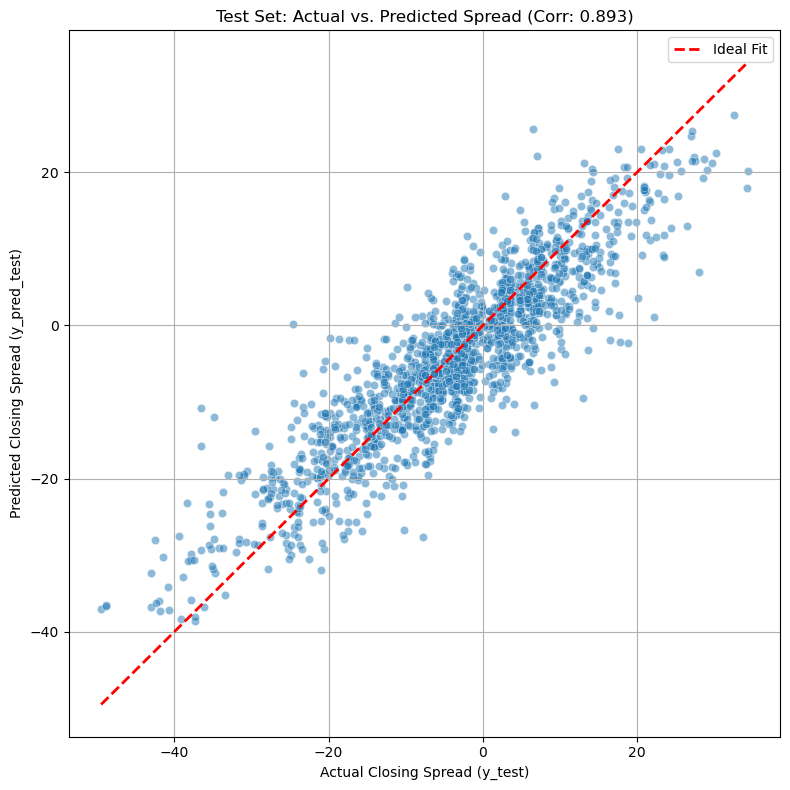


--- Test Set Betting Performance ---
  Total Bets:   1241
  Wins:         639
  Losses:       593
  Pushes:       9
  Win Rate:     51.87%
  Total Units:  -12.15
  ROI:          -0.99%


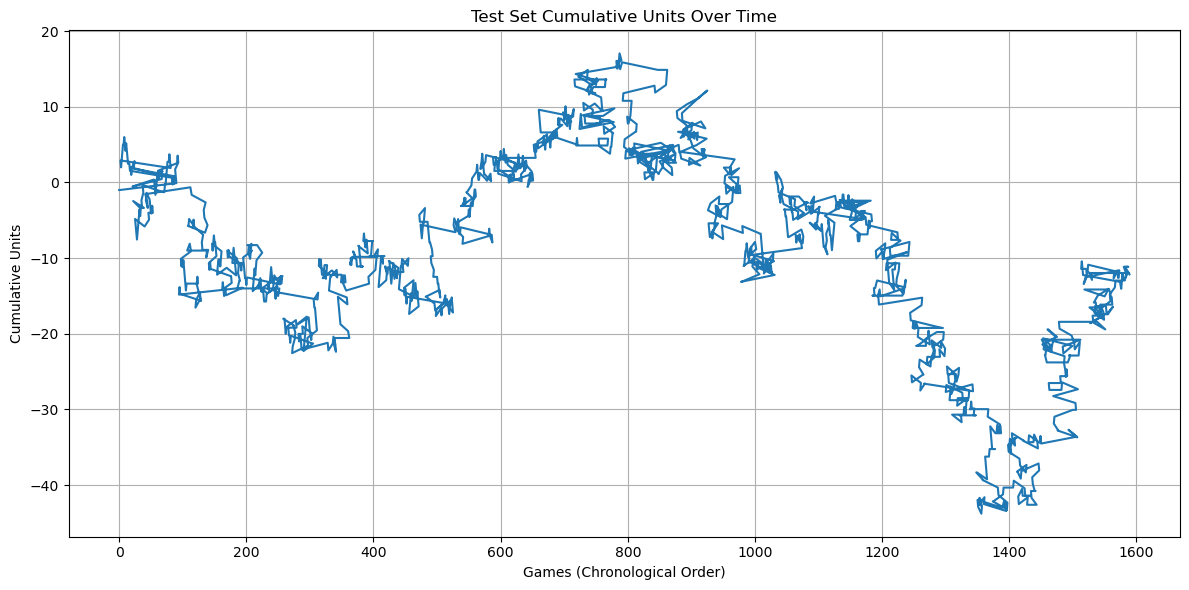

In [17]:
# Evaluate Statistical Metrics on Test Set
win_rate = MF.evaluate_model_statistics(y_test, y_pred_test, predictions_test_series, test_df, VAL_REQUIRED_COLS, WIN_PAYOUT, LOSS_AMOUNT, BET_THRESHOLD)

## Save Final Model

In [19]:
import json
final_model.save_model("final_model.json")
with open('final_model_best_features.json', 'w') as f:
    json.dump(best_features, f)
